# GeoGuessr Machine Learning-Ansatz

## Zusatzinformationen

## Code

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Imports für Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import cv2
import os

ModuleNotFoundError: No module named 'matplotlib'

### Functions

In [2]:
def get_data(data_dir, labels, appendix, cnt, img_size):
    data = [] 
    for label in labels: 
        internCounter = cnt/len(labels);
        path = os.path.join(data_dir, label, appendix, 'images')
        class_num = labels.index(label)
        for img in os.listdir(path):
            if(internCounter <= 0):
                break;
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = list(cv2.resize(img_arr, (img_size, img_size))) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
            internCounter = internCounter -1;
    return data

In [3]:
def split_train_val(train, val, img_size):
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    for feature, label in train:
        x_train.append(feature)
        y_train.append(label)

    for feature, label in val:
        x_val.append(feature)
        y_val.append(label)

    # Normalize the data
    x_train = np.array(x_train) / 255
    x_val = np.array(x_val) / 255

    x_train.reshape(-1, img_size, img_size, 1)
    y_train = np.array(y_train)

    x_val.reshape(-1, img_size, img_size, 1)
    y_val = np.array(y_val)
    
    return x_train, y_train, x_val, y_val

In [4]:
def generate_model(img_size):
    model = Sequential()
    model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, 3)))
    model.add(MaxPool2D())

    model.add(Conv2D(32, 3, padding="same", activation="relu"))
    model.add(MaxPool2D())

    model.add(Conv2D(64, 3, padding="same", activation="relu"))
    model.add(MaxPool2D())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dense(len(cities), activation="softmax"))
    
    return model

In [5]:
def train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range):
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

    history = model.fit(x_train,y_train,epochs = epoch_range , validation_data = (x_val, y_val))
    
    return model, history

In [6]:
def plot_history(history, epoch_range):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt
    

In [7]:
def get_metrics(model, labels, x_val, y_val):
    predictionOdds = model.predict(x_val)
    predictions = []
    for pred in predictionOdds:
        predictions.append(list(pred).index(max(pred)))

    predictions = np.array(predictions)
    predictions = predictions.reshape(1,-1)[0]
    return classification_report(y_val, predictions, target_names = labels);

In [10]:
def create_neural_network(img_size, processed_images, train_split, labels, epoch_range, learning_rate):
    train_images = int(processed_images * train_split)
    val_images = int(processed_images - train_images)
    
    train = get_data('/home/fhase/Desktop/Dataset_S', labels, 'database', train_images, img_size)
    val = get_data('/home/fhase/Desktop/Dataset_S', labels, 'query', val_images, img_size)
                  
    x_train, y_train, x_val, y_val = split_train_val(train, val, img_size)
    
    model = generate_model(img_size)
    print(model.summary())
    
    model, history = train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range)
    
    plt = plot_history(history, epoch_range)
    metrics = get_metrics(model, labels, x_val, y_val)
    
    

### Deep Learning

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 450, 450, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 225, 225, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 225, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0

2023-04-05 17:14:05.302591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-05 17:14:05.303047: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


None
Epoch 1/5


2023-04-05 17:14:06.215325: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3892860000 exceeds 10% of free system memory.
/home/fhase/.local/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


51/51 [==============================] - 104s 2s/step - loss: 1.7880 - accuracy: 0.1785 - val_loss: 1.7720 - val_accuracy: 0.2463
Epoch 2/5
51/51 [==============================] - 103s 2s/step - loss: 1.7663 - accuracy: 0.2135 - val_loss: 1.7521 - val_accuracy: 0.2537
Epoch 3/5
51/51 [==============================] - 103s 2s/step - loss: 1.7485 - accuracy: 0.2865 - val_loss: 1.7289 - val_accuracy: 0.3507
Epoch 4/5
51/51 [==============================] - 103s 2s/step - loss: 1.7301 - accuracy: 0.2921 - val_loss: 1.7068 - val_accuracy: 0.4204
Epoch 5/5
13/13 [==============================] - 5s 340ms/step


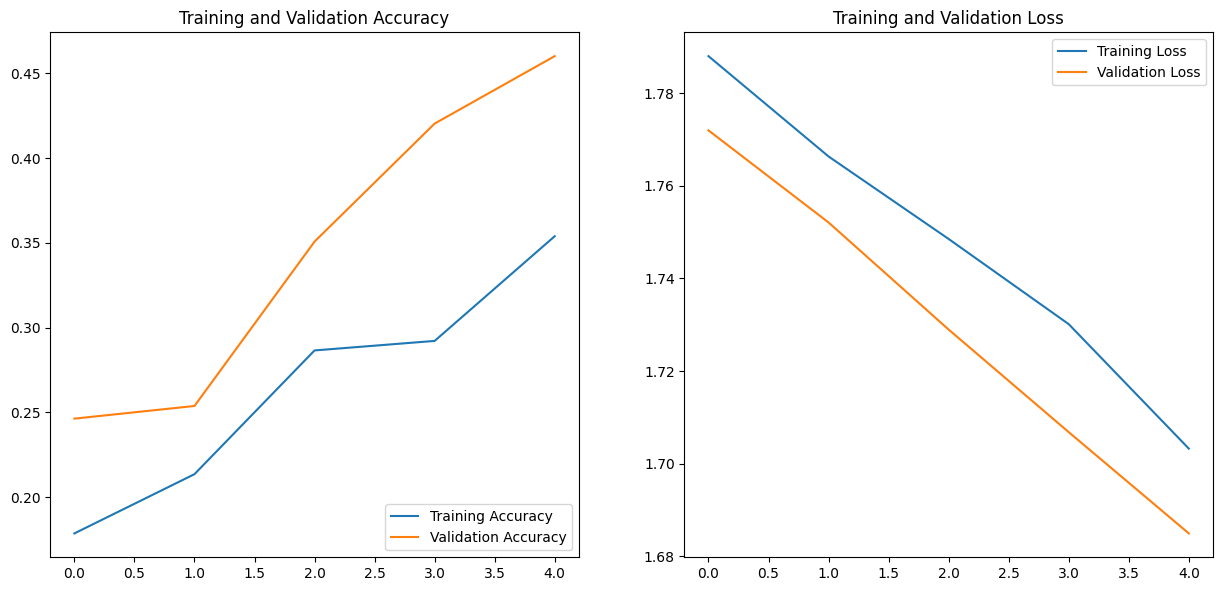

In [11]:
cities = ['berlin', 'kampala', 'melbourne', 'saopaulo', 'sf', 'tokyo']
create_neural_network(450, 2000, 0.8, cities, 5, 0.000001)